In [1]:
import os
from glob import glob
import re 
import math
from pathlib import Path 
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as skm
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import mne
mne.set_log_level(verbose=False)

from Datasets import *

from utils_folder.callbacks import *
from utils_folder.training_pth import *
from utils_folder.plotting import *
from utils_folder.utils import get_labels_and_preds

In [2]:
def get_order(file_path):
    """
    Used to order the results from glob, so that the patients are
    properly concatenated.
    """
    match = file_pattern.match(Path(file_path).name)
    if not match:
        return math.inf
    return int(match.groups()[0])

In [3]:
BINARY = False

In [4]:
## Define the regex to sort the files and obtain the paths list
file_pattern = re.compile(r'.*?(\d+).*?')
sorted_files = sorted(glob("/media/usbdisk/data/ProyectoPSG/data/*.edf"), key=get_order)
### Remove the 10th patient
sorted_files_no_10 = [a for a in sorted_files if re.findall(r'\d+', a)[0]!='10']

## Load the data
datasets = [EDFData_PTH(path_glob, binary=BINARY) for path_glob in tqdm(sorted_files_no_10)]

## Concat all the individual files' datasets
dataset_concat = torch.utils.data.ConcatDataset(datasets)

  0%|          | 0/19 [00:00<?, ?it/s]

In [5]:
## Train-Test split using Pablo's indexes
### Load indexes. They have to be either ints or booleans.
idx_train = np.loadtxt("../indices_train.txt").astype(int)
idx_val = np.loadtxt("../indices_val.txt").astype(int)
idx_test = np.loadtxt("../indices_test_2.txt").astype(int)
### Subset the concatenated dataset
train = torch.utils.data.Subset(dataset_concat, indices=idx_train)
val = torch.utils.data.Subset(dataset_concat, indices=idx_val)
test = torch.utils.data.Subset(dataset_concat, indices=idx_test)
print(f"Using {len(dataset_concat)} samples to train: {len(train)} (Train) & {len(val)} (Validation) & {len(test)} (Test).")

Using 15041 samples to train: 9776 (Train) & 2632 (Validation) & 2633 (Test).


In [6]:
CHANNELS = ['CHIN1']

In [7]:
dataset_npy = [dataset.epochs.get_data(picks=CHANNELS) for dataset in tqdm(datasets)]
dataset_npy = np.concatenate(dataset_npy)
dataset_npy.shape

  0%|          | 0/19 [00:00<?, ?it/s]

(15041, 1, 15360)

In [8]:
train_npy = dataset_npy[idx_train]
val_npy = dataset_npy[idx_val]
test_npy = dataset_npy[idx_test]
print(train_npy.shape, val_npy.shape, test_npy.shape)

(9776, 1, 15360) (2632, 1, 15360) (2633, 1, 15360)


## Histogramas

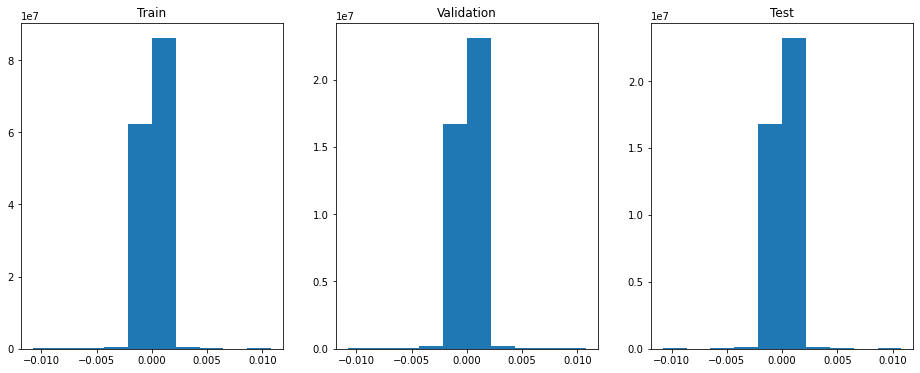

In [11]:
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.title("Train")
plt.hist(train_npy[:,0,:].ravel())
plt.subplot(1,3,2)
plt.title("Validation")
plt.hist(val_npy[:,0,:].ravel())
plt.subplot(1,3,3)
plt.title("Test")
plt.hist(test_npy[:,0,:].ravel())
plt.show()

We can't plot all the epochs, because the computer dies when trying to plot almost 10k series of 15k elements, so we will have to resort to smaller batches. Anyway, we can't visually inspect a lot at the same time, so it should suffice. We will check the first 5 samples in each set to start off.

In [9]:
threshold = 0.001

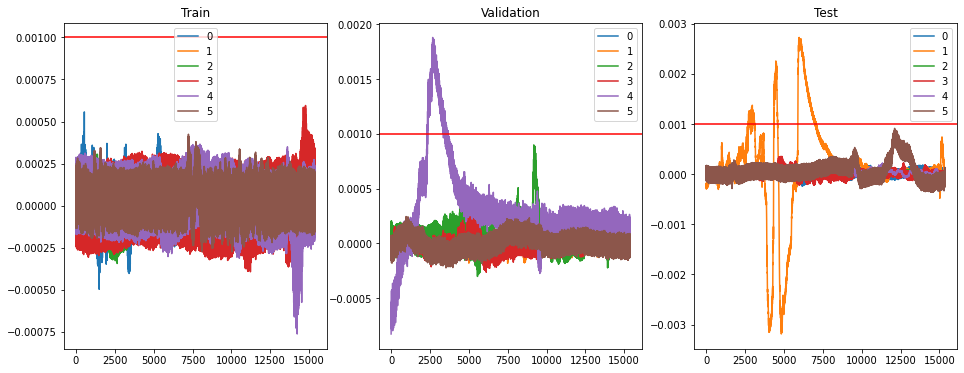

In [26]:
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.title("Train")
for i in range(len(train_npy)):
    plt.plot(train_npy[i,0,:], label=i)
    if i == 5:
        break
plt.axhline(threshold, c='r')
plt.legend()
plt.subplot(1,3,2)
plt.title("Validation")
for i in range(len(val_npy)):
    plt.plot(val_npy[i,0,:], label=i)
    if i == 5:
        break
plt.axhline(threshold, c='r')
plt.legend()
plt.subplot(1,3,3)
plt.title("Test")
for i in range(len(test_npy)):
    plt.plot(test_npy[i,0,:], label=i)
    if i == 5:
        break
plt.axhline(threshold, c='r')
plt.legend()
plt.show()

We can see that there are **veeeeery** different samples that come out above the rest. By simple visual exploration we got to a threshold that would get rid of the most exagerated samples. Let's see how many epochs would surpass this threshold:

In [10]:
# We're making them arrays to be able to negate them later.
val_above_th = np.array([a.any() for a in (val_npy > threshold)])
test_above_th = np.array([a.any() for a in (test_npy > threshold)])
sum(val_above_th), sum(test_above_th)

(261, 210)

In [42]:
val_npy[~val_above_th].shape

(2371, 1, 15360)

## Assessing similarities between epochs
It'd be nice to have kind of a metric that would tell us how different are the samples in a set so that these iterations can be performed faster...

In [11]:
df_val = pd.DataFrame(val_npy.squeeze())
print("{} rows and {} columns.".format(*df_val.shape))
df_val.head()

2632 rows and 15360 columns.


0         1         2         3         4         5             6      \
0 -0.000039 -0.000038 -0.000038 -0.000042 -0.000050 -0.000052 -5.059281e-05   
1  0.000070  0.000081  0.000082  0.000066  0.000051  0.000057  5.158160e-05   
2  0.000188  0.000130  0.000062 -0.000007 -0.000043 -0.000062 -1.104143e-05   
3 -0.000073 -0.000046 -0.000007  0.000052  0.000060  0.000050  4.943923e-07   
4 -0.000827 -0.000821 -0.000769 -0.000669 -0.000645 -0.000610 -6.557290e-04   

      7         8         9      ...     15350     15351     15352     15353  \
0 -0.000050 -0.000048 -0.000037  ...  0.000022  0.000022  0.000019  0.000018   
1  0.000028  0.000036  0.000047  ...  0.000100  0.000092  0.000082  0.000101   
2  0.000067  0.000151  0.000189  ...  0.000007 -0.000041 -0.000072 -0.000035   
3 -0.000039 -0.000086 -0.000107  ... -0.000021  0.000027  0.000042  0.000048   
4 -0.000699 -0.000713 -0.000733  ...  0.000140  0.000080  0.000006 -0.000005   

      15354     15355     15356     15357     15358     15359  
0  0.000018  0.000017  0.000018  0.000018  0.000012  0.000011  
1  0.000126  0.000110  0.000088  0.000061  0.000053  0.000065  
2  0.000023  0.000098  0.000153  0.000185  0.000155  0.000095  
3  0.000014 -0.000020 -0.000066 -0.000072 -0.000071 -0.000039  
4 -0.000004  0.000065  0.000132  0.000187  0.000220  0.000238  

[5 rows x 15360 columns]

In [12]:
df_val.describe()

0            1            2            3            4      \
count  2632.000000  2632.000000  2632.000000  2632.000000  2632.000000   
mean      0.000035     0.000043     0.000038     0.000026     0.000007   
std       0.000703     0.000727     0.000707     0.000692     0.000713   
min      -0.009815    -0.008303    -0.010800    -0.010800    -0.010800   
25%      -0.000048    -0.000044    -0.000042    -0.000044    -0.000052   
50%       0.000016     0.000020     0.000020     0.000016     0.000015   
75%       0.000090     0.000090     0.000087     0.000082     0.000081   
max       0.010800     0.010800     0.010800     0.010691     0.010707   

             5            6            7            8            9      ...  \
count  2632.000000  2632.000000  2632.000000  2632.000000  2632.000000  ...   
mean     -0.000006    -0.000014    -0.000013    -0.000002     0.000016  ...   
std       0.000704     0.000691     0.000672     0.000636     0.000644  ...   
min      -0.010800    -0.010800    -0.010800    -0.010800    -0.010577  ...   
25%      -0.000057    -0.000057    -0.000055    -0.000049    -0.000048  ...   
50%       0.000014     0.000011     0.000013     0.000016     0.000018  ...   
75%       0.000081     0.000074     0.000079     0.000080     0.000085  ...   
max       0.009981     0.008154     0.006772     0.007458     0.009940  ...   

             15350        15351        15352        15353        15354  \
count  2632.000000  2632.000000  2632.000000  2632.000000  2632.000000   
mean     -0.000010    -0.000008    -0.000004     0.000014     0.000022   
std       0.000796     0.000814     0.000777     0.000703     0.000702   
min      -0.010800    -0.010800    -0.010800    -0.010800    -0.010800   
25%      -0.000049    -0.000048    -0.000048    -0.000048    -0.000049   
50%       0.000016     0.000015     0.000014     0.000015     0.000017   
75%       0.000086     0.000079     0.000080     0.000085     0.000085   
max       0.010800     0.010380     0.010739     0.010028     0.009023   

             15355        15356        15357        15358        15359  
count  2632.000000  2632.000000  2632.000000  2632.000000  2632.000000  
mean      0.000033     0.000024     0.000023     0.000009    -0.000004  
std       0.000776     0.000821     0.000801     0.000720     0.000735  
min      -0.010800    -0.010800    -0.010800    -0.010800    -0.010800  
25%      -0.000046    -0.000047    -0.000045    -0.000046    -0.000047  
50%       0.000018     0.000019     0.000019     0.000018     0.000018  
75%       0.000084     0.000093     0.000090     0.000085     0.000086  
max       0.010800     0.010558     0.010800     0.008762     0.006707  

[8 rows x 15360 columns]

In [13]:
describe_val = df_val.describe().mean(axis=1)
describe_val

count    2632.000000
mean        0.000009
std         0.000739
min        -0.010733
25%        -0.000049
50%         0.000016
75%         0.000082
max         0.010081
dtype: float64

In [14]:
df_val_th = pd.DataFrame(val_npy[~val_above_th].squeeze())
print("{} rows and {} columns.".format(*df_val_th.shape))
df_val_th.head()

2371 rows and 15360 columns.


0         1         2         3         4         5             6      \
0 -0.000039 -0.000038 -0.000038 -0.000042 -0.000050 -0.000052 -5.059281e-05   
1  0.000070  0.000081  0.000082  0.000066  0.000051  0.000057  5.158160e-05   
2  0.000188  0.000130  0.000062 -0.000007 -0.000043 -0.000062 -1.104143e-05   
3 -0.000073 -0.000046 -0.000007  0.000052  0.000060  0.000050  4.943923e-07   
4  0.000026  0.000066  0.000073  0.000046 -0.000025 -0.000093 -1.465049e-04   

      7         8         9      ...     15350     15351     15352     15353  \
0 -0.000050 -0.000048 -0.000037  ...  0.000022  0.000022  0.000019  0.000018   
1  0.000028  0.000036  0.000047  ...  0.000100  0.000092  0.000082  0.000101   
2  0.000067  0.000151  0.000189  ...  0.000007 -0.000041 -0.000072 -0.000035   
3 -0.000039 -0.000086 -0.000107  ... -0.000021  0.000027  0.000042  0.000048   
4 -0.000153 -0.000134 -0.000074  ... -0.000131 -0.000131 -0.000081 -0.000023   

      15354     15355     15356     15357     15358     15359  
0  0.000018  0.000017  0.000018  0.000018  0.000012  0.000011  
1  0.000126  0.000110  0.000088  0.000061  0.000053  0.000065  
2  0.000023  0.000098  0.000153  0.000185  0.000155  0.000095  
3  0.000014 -0.000020 -0.000066 -0.000072 -0.000071 -0.000039  
4  0.000051  0.000081  0.000089  0.000046 -0.000007 -0.000073  

[5 rows x 15360 columns]

In [15]:
describe_val_th = df_val_th.describe().mean(axis=1)
describe_val_th

count    2371.000000
mean        0.000015
std         0.000164
min        -0.003386
25%        -0.000043
50%         0.000015
75%         0.000074
max         0.000746
dtype: float64

Actually, there is a great change in the proportion between ```25%```-```min``` and ```75%```-```max```. I'm not sure about using this proportion for anything, but it kind of makes sense to use it as a measure of instantaneous spikes:
> If the ```75%``` and ```max``` are very different, that means that there is a great spike but there aren't too many, because the ```75%``` of the data is below it. Even further, if they are very different it can be another indication of a too-big spike happening maybe?

In [16]:
print("Ratio Max-75%: ", describe_val['max'] / describe_val['75%'])
print(f"Ratio Max-75% [Thresholded ({threshold})]: ", describe_val_th['max'] / describe_val_th['75%'])

Ratio Max-75%:  122.75659302060139
Ratio Max-75% [Thresholded (0.001)]:  10.013727655058965


In [17]:
print("Ratio Min-25%: ", describe_val['min'] / describe_val['25%'])
print(f"Ratio Min-25% [Thresholded ({threshold})]: ", describe_val_th['min'] / describe_val_th['25%'])

Ratio Min-25%:  218.41405527912326
Ratio Min-25% [Thresholded (0.001)]:  78.11685966564154


In this link https://datascience.stackexchange.com/questions/15812/check-similarity-between-time-series some people talk about using ```Pearson Correlation Coefficient``` or ```Cosine Similarity``` to assess similarity between time series, but say that ```Pearson Correlation Coefficient``` would be better because it's invariant to scaling. We could use that as well in two different ways:
1. Calculate the similarity between all the series in a set before and after removing some.
2. Calculate the similarity between the rejected and the non-rejected series.

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

In [49]:
def plot_vs_series_r_cs(dataset, index_1, index_2):
    r, p = pearsonr(dataset[index_1].squeeze(), dataset[index_2].squeeze())
    cs = cosine_similarity(dataset[index_1], dataset[index_2])
    plt.figure()
    plt.title(f"R: {r} | CS: {cs.item()}")
    plt.plot(dataset[index_1].squeeze(), label=index_1)
    plt.plot(dataset[index_2].squeeze(), label=index_2)
    plt.legend()
    plt.show()

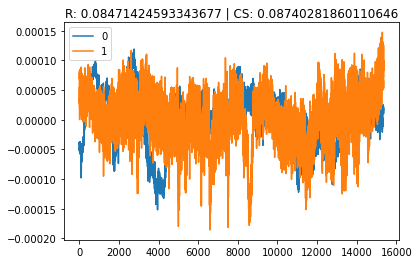

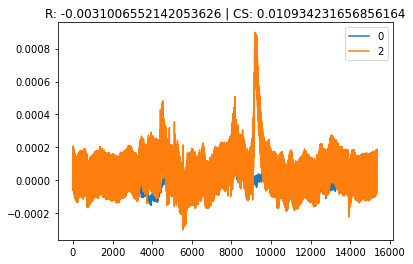

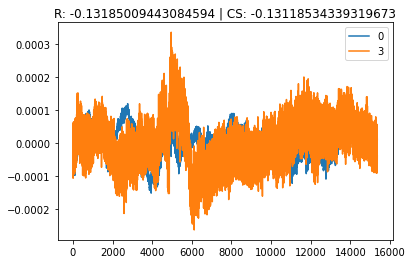

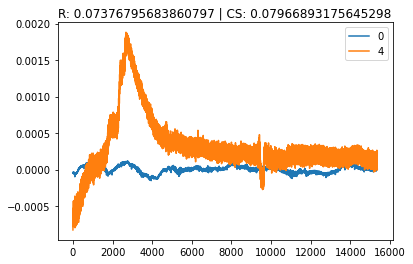

In [52]:
for i in range(1,5):
    plot_vs_series_r_cs(val_npy, 0, i)

In [33]:
def get_r_p(dataset):
    pearsonrs = []
    pearsonrp = []
    for i in range(len(dataset)-1):
        r, p = pearsonr(dataset[i].squeeze(), dataset[i+1].squeeze())
        pearsonrs.append(r)
        pearsonrp.append(p)
    
    return pearsonrs, pearsonrp

In [34]:
r_train, p_train = get_r_p(train_npy)
r_val, p_val = get_r_p(val_npy)
r_test, p_test = get_r_p(test_npy)

In [35]:
np.mean(r_train), np.mean(r_val), np.mean(r_test)

(-0.0013356860163114893, -0.0013806655010758547, -0.00047799784806716524)